In [1]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import general_functions


In [2]:
def adjust_r_one_step(p, r):
    r = r[:, None] 
    p = p[None, :]
    return (1 + r) / (1 - p) - 1


def adjust_r(p, r):
    r = r[:, None] 
    p = p[None, :]
    return r * p /((1 + r) * (1 - p))


def plot_adjust_r(p_values, r_values):
    # Calculate data
    adjusted_r_values = adjust_r(p_values, r_values)
    adjusted_r_values_one_step = adjust_r_one_step(p_values, r_values)
    
    # Find masks of different interesting areas    
    mask = adjusted_r_values > r_values[:, None]  # Area where adjusted r is greater than r
    mask_assumption_wrong = (1 - p_values[None, :]) * (1 + r_values[:, None]) > 1

    # Create fig and unpack axis
    fig, ax_arr = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
    ax = ax_arr[0, 0]
    ax1 = ax_arr[0, 1]
    ax2 = ax_arr[1, 0]
    ax3 = ax_arr[1, 1]
    
    # Axis 0 - Adjusted r
    im = ax.contourf(p_values, r_values, adjusted_r_values, levels=30, cmap="viridis")
    # Add magnitude labels to the contour plot
    contours = ax.contour(p_values, r_values, adjusted_r_values, levels=30, cmap="binary", linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
    
    # Masks
    ax.contour(p_values, r_values, mask, levels=[0.5], colors='blue', linestyles='-', linewidths=3)  # Mask for r_D > r
    ax.contourf(p_values, r_values, np.logical_not(mask_assumption_wrong), levels=[0, 0.1], colors='red')  # logical_not to get the colours right, otherwise makes the correct area red.
    
    # Axis setup
    ax.set_ylabel(r"Free interest $r_f$")
    ax.set_title(r"Adjusted interest $r$")
    
    # Custom legend for the contour plot of the mask
    custom_lines = [Line2D([0], [0], color='blue', linestyle='-', lw=2, label="r > r_f (right of line)"), 
                    Line2D([0], [0], color='red', linestyle='-', lw=2, label="Assumption wrong")]
    ax.legend(handles=custom_lines, loc="upper left")
    
    # Axis 1 - Percentage difference
    percent_diff = (adjusted_r_values - r_values[:, None]) / r_values[:, None] * 100
    
    im2 = ax1.contourf(p_values, r_values, percent_diff, levels=30, cmap="viridis")  # Contour fill
    contours2 = ax1.contour(p_values, r_values, percent_diff, levels=30, cmap="binary", linewidths=0.5)  # Contour lines
    ax1.contourf(p_values, r_values, np.logical_not(mask_assumption_wrong), levels=[0, 0.1], colors='red')  # Mask for r_D > r. logical_not to get the colours right, otherwise makes the correct area red.
    
    ax1.clabel(contours2, inline=True, fontsize=8, fmt="%.2f")
    # Axis 1 setup
    ax1.set_title(r"Percentage difference in $r$ and $r_f$")
    # Custom legend for the contour plot of the mask
    custom_lines_ax1 = [Line2D([0], [0], color='red', linestyle='-', lw=2, label="Assumption wrong")]
    ax1.legend(handles=custom_lines_ax1, loc="upper left")
    
    # Axis 2 - Adjusted r one step
    # Plot 
    im3 = ax2.contourf(p_values, r_values, adjusted_r_values_one_step, levels=30, cmap="viridis")
    contours3 = ax2.contour(p_values, r_values, adjusted_r_values_one_step, levels=30, cmap="binary", linewidths=0.5)
    ax2.clabel(contours3, inline=True, fontsize=8, fmt="%.2f")
    # Axis setup
    ax2.set(xlabel="Probability of default $P_D$", ylabel="Free interest $r_f$", title="Adjusted interest $r$ one step")
    
    # Axis 3 - Percentage difference one step
    percent_diff_one_step = (adjusted_r_values_one_step - r_values[:, None]) / r_values[:, None] * 100
    im4 = ax3.contourf(p_values, r_values, percent_diff_one_step, levels=60, cmap="viridis")
    contours4 = ax3.contour(p_values, r_values, percent_diff_one_step, levels=60, cmap="binary", linewidths=0.5)
    ax3.clabel(contours4, inline=True, fontsize=8, fmt="%.2f")
    # Axis setup
    ax3.set(xlabel="Probability of default $P_D$", title="Percentage difference in $r$ and $r_f$ one step")
    
    # Figure title and colorbars
    fig.colorbar(im, ax=ax, label=r"$r_D$")
    fig.colorbar(im2, ax=ax1, label="Percentage difference")
    fig.colorbar(im3, ax=ax2, label=r"$r_D$")
    fig.colorbar(im4, ax=ax3, label="Percentage difference")
    
    fig.suptitle(r"$r = r_f \, P_D / \left[(1+r_f)(1-P_D)\right]$ vs $r = (1 + r_f) / (1 - P_D) - 1$", fontsize=12)
    plt.show()

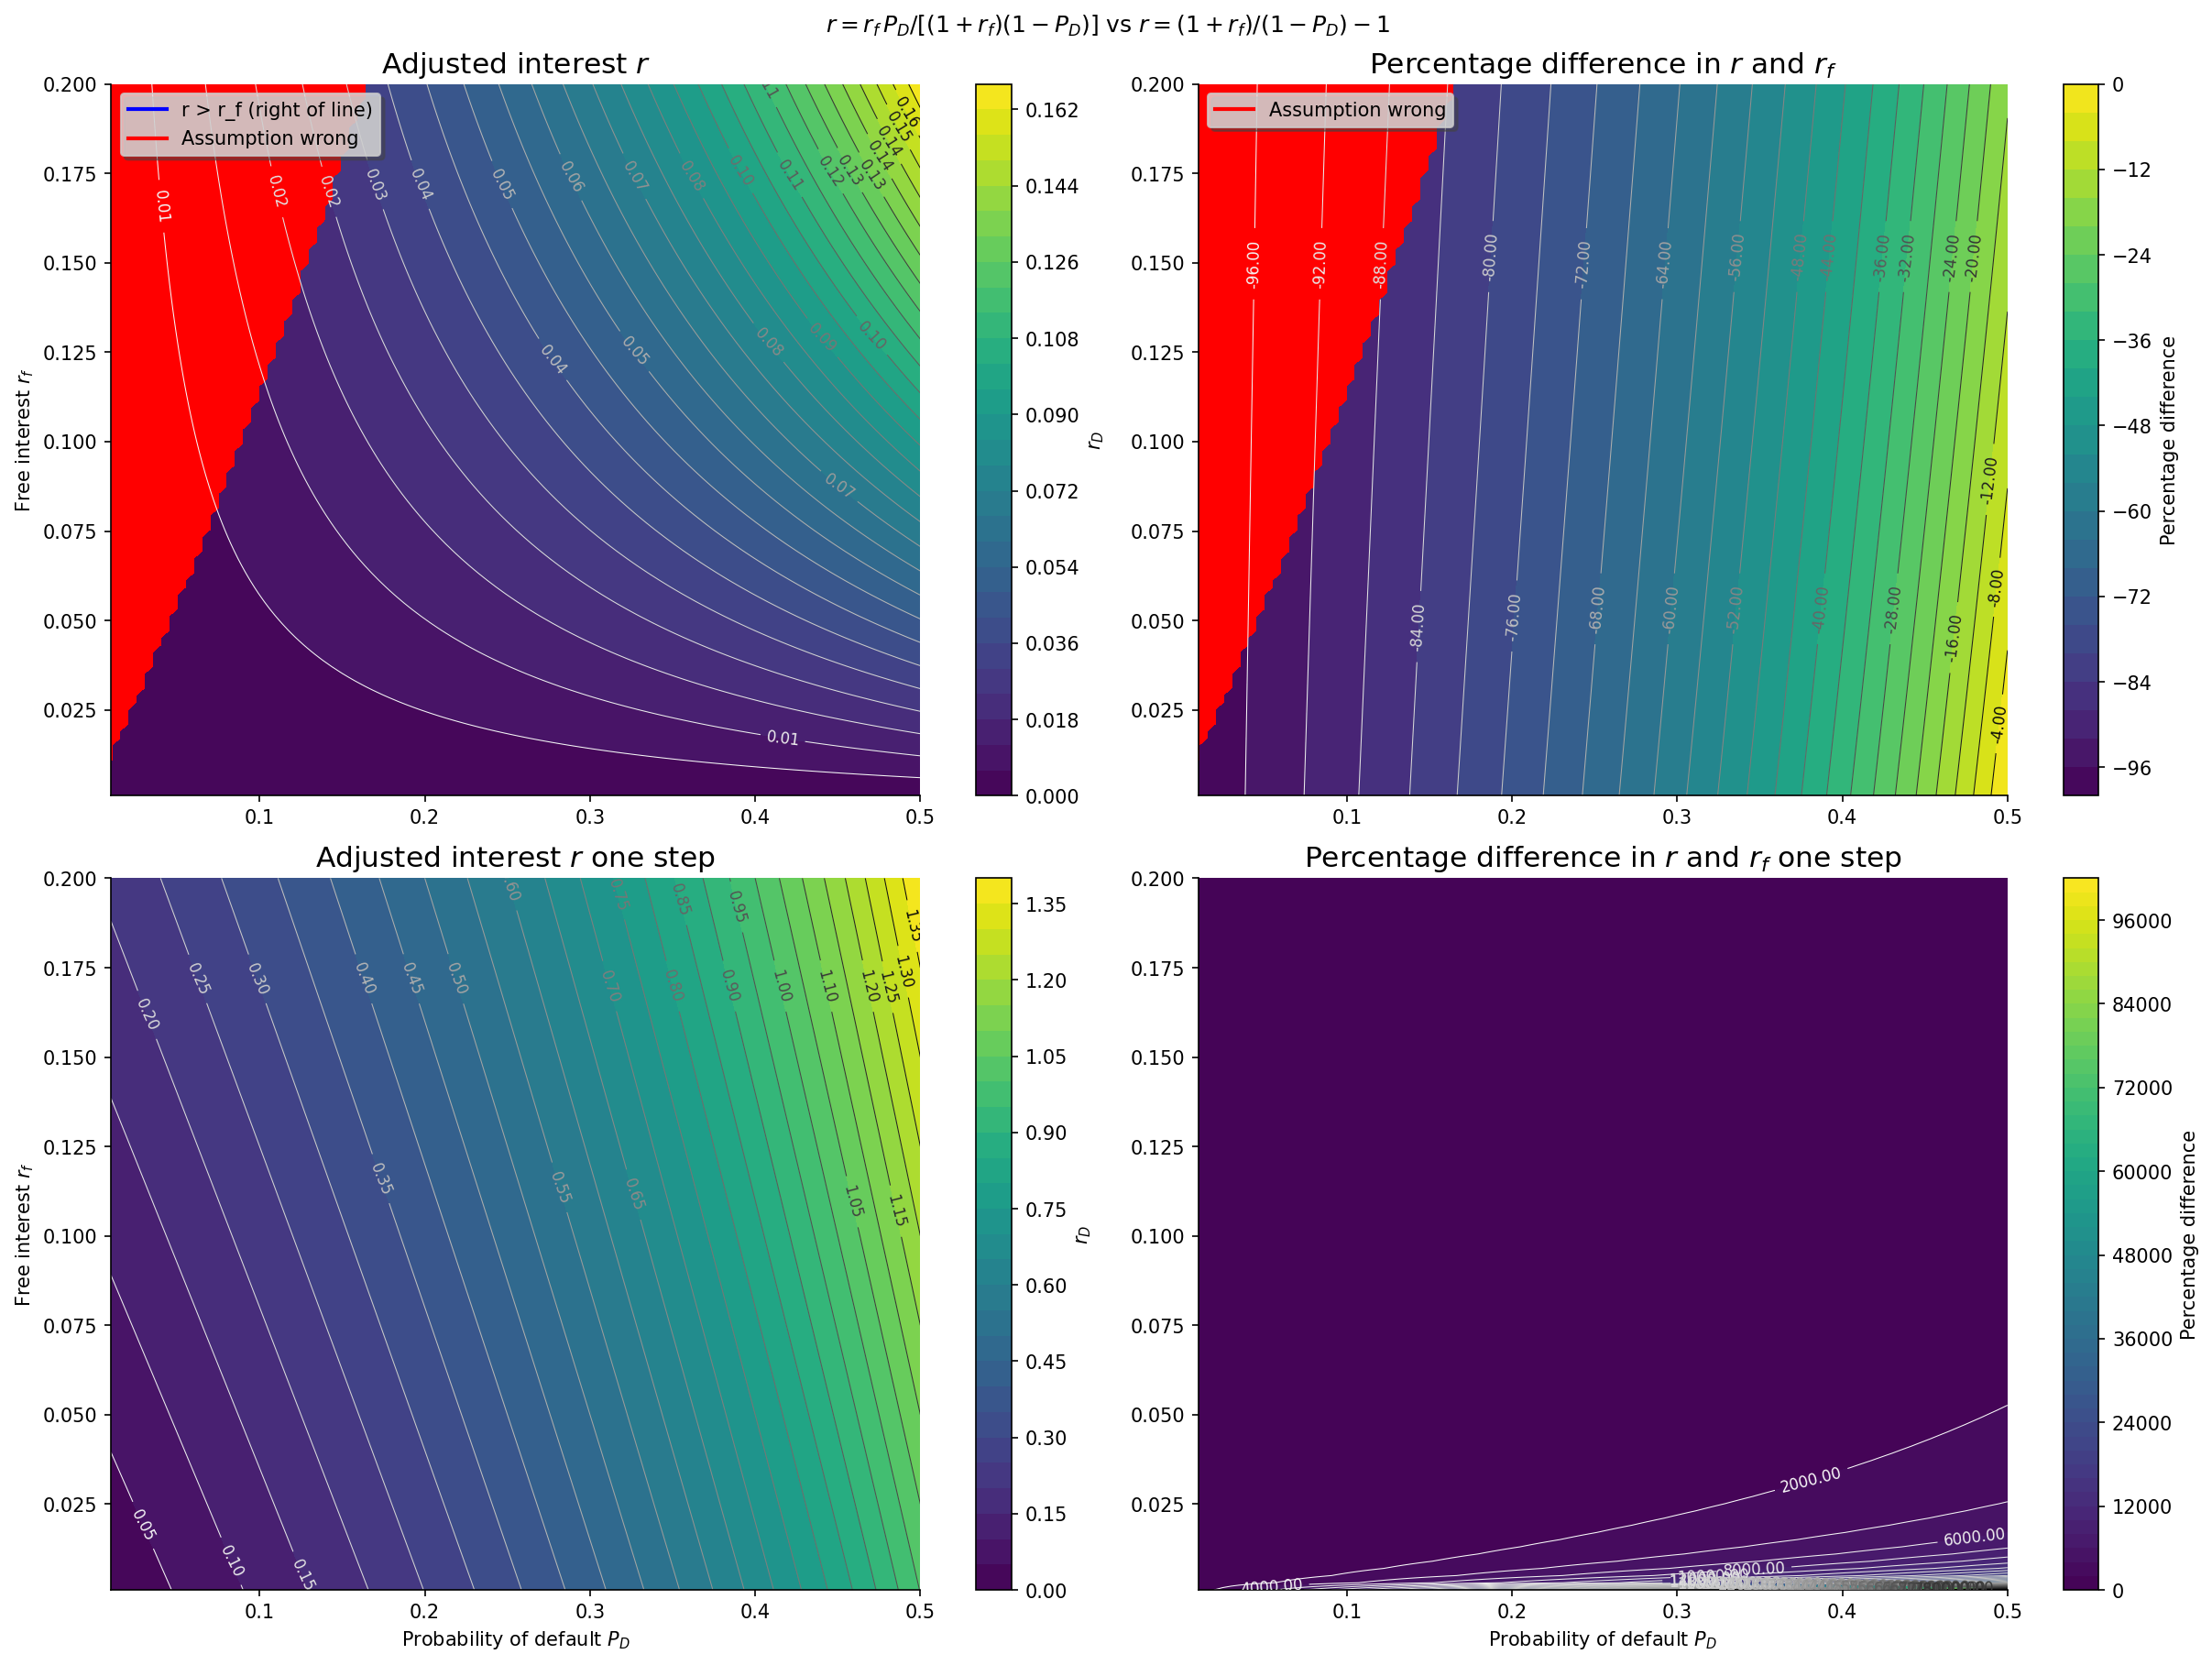

In [11]:
p = np.linspace(0.01, 0.5, 100)
r = np.linspace(0.001, 0.2, 100)  
plot_adjust_r(p, r)

Note that in the one step formula, $r$ is always greater than $r_f$

## Bisection method

In [8]:
from scipy.optimize import bisect

def bisect_adjusted_r(T):
    def f(r, PD, r_f, T):
        # Define the expected return function
        term1 = PD * (1 - ((1 - PD) * (1 + r))**T) / (1 - (1 - PD) * (1 + r))
        term2 = ((1 - PD) * (1 + r))**T
        term3 = - (1 + r_f)**T
        return term1 + term2 + term3

    # Define the range for r such that f(r_min ...) and f(r_max ...) have different signs (i.e. the root is in between)
    r_min, r_max = -0.99, 25

    p_values = np.linspace(0.01, 0.2, 100)
    r_values = np.logspace(-4, -1, 100)

    # Solve for each combination of PD and r_f
    r_solutions = np.zeros((len(p_values), len(r_values)))
    for j, PD in enumerate(p_values):
        for i, r_f in enumerate(r_values):
            r_solutions[i, j] = bisect(f, r_min, r_max, args=(PD, r_f, T))

    # Find masks of different interesting areas    
    mask = r_solutions > r_values[:, None]  # Area where adjusted r is greater than r

    # Calculate the percentage difference
    percent_diff = (r_solutions - r_values[:, None]) / r_values[:, None]

    # Plot the solutions
    fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    ax1 = ax_arr[0]
    ax2 = ax_arr[1]

    # Contour plot for r_solutions
    # levels = [0, 0.2, 0.5, 0.75, 1.25, 2.5, 4, 5, 6, r_solutions.max()]
    levels=20
    # c1 = ax1.contourf(p_values, r_values, r_solutions.T, levels=levels, cmap="viridis")
    c1 = ax1.imshow(r_solutions, extent=[p_values.min(), p_values.max(), r_values.min(), r_values.max()], origin='lower', aspect='auto', cmap='viridis')

    # Text contour lines
    contours1 = ax1.contour(p_values, r_values, r_solutions, levels=levels, colors='black', linewidths=0.5)
    ax1.clabel(contours1, inline=True, fontsize=8, fmt="%.2f")

    # Masks
    ax1.contour(p_values, r_values, mask, levels=[0.5], colors='blue', linestyles='-', linewidths=3)  # Mask for r_D > r

    fig.colorbar(c1, ax=ax1, label='r adjusted')
    ax1.set_xlabel('Probability of default $P_D$')
    ax1.set_ylabel('Free interest $r_f$')

    # Contour plot for percentage difference
    levels_diff = np.linspace(percent_diff.min(), percent_diff.max(), 30)
    c2 = ax2.contourf(p_values, r_values, percent_diff, levels=levels_diff, cmap="viridis")

    # Text contour lines
    contours2 = ax2.contour(p_values, r_values, percent_diff, levels=levels_diff, colors='black', linewidths=0.5)
    ax2.clabel(contours2, inline=True, fontsize=8, fmt="%.2f")

    fig.colorbar(c2, ax=ax2, label='Percentage difference')
    ax2.set_xlabel('Probability of default $P_D$')
    ax2.set_ylabel('Free interest $r_f$')

    plt.show()

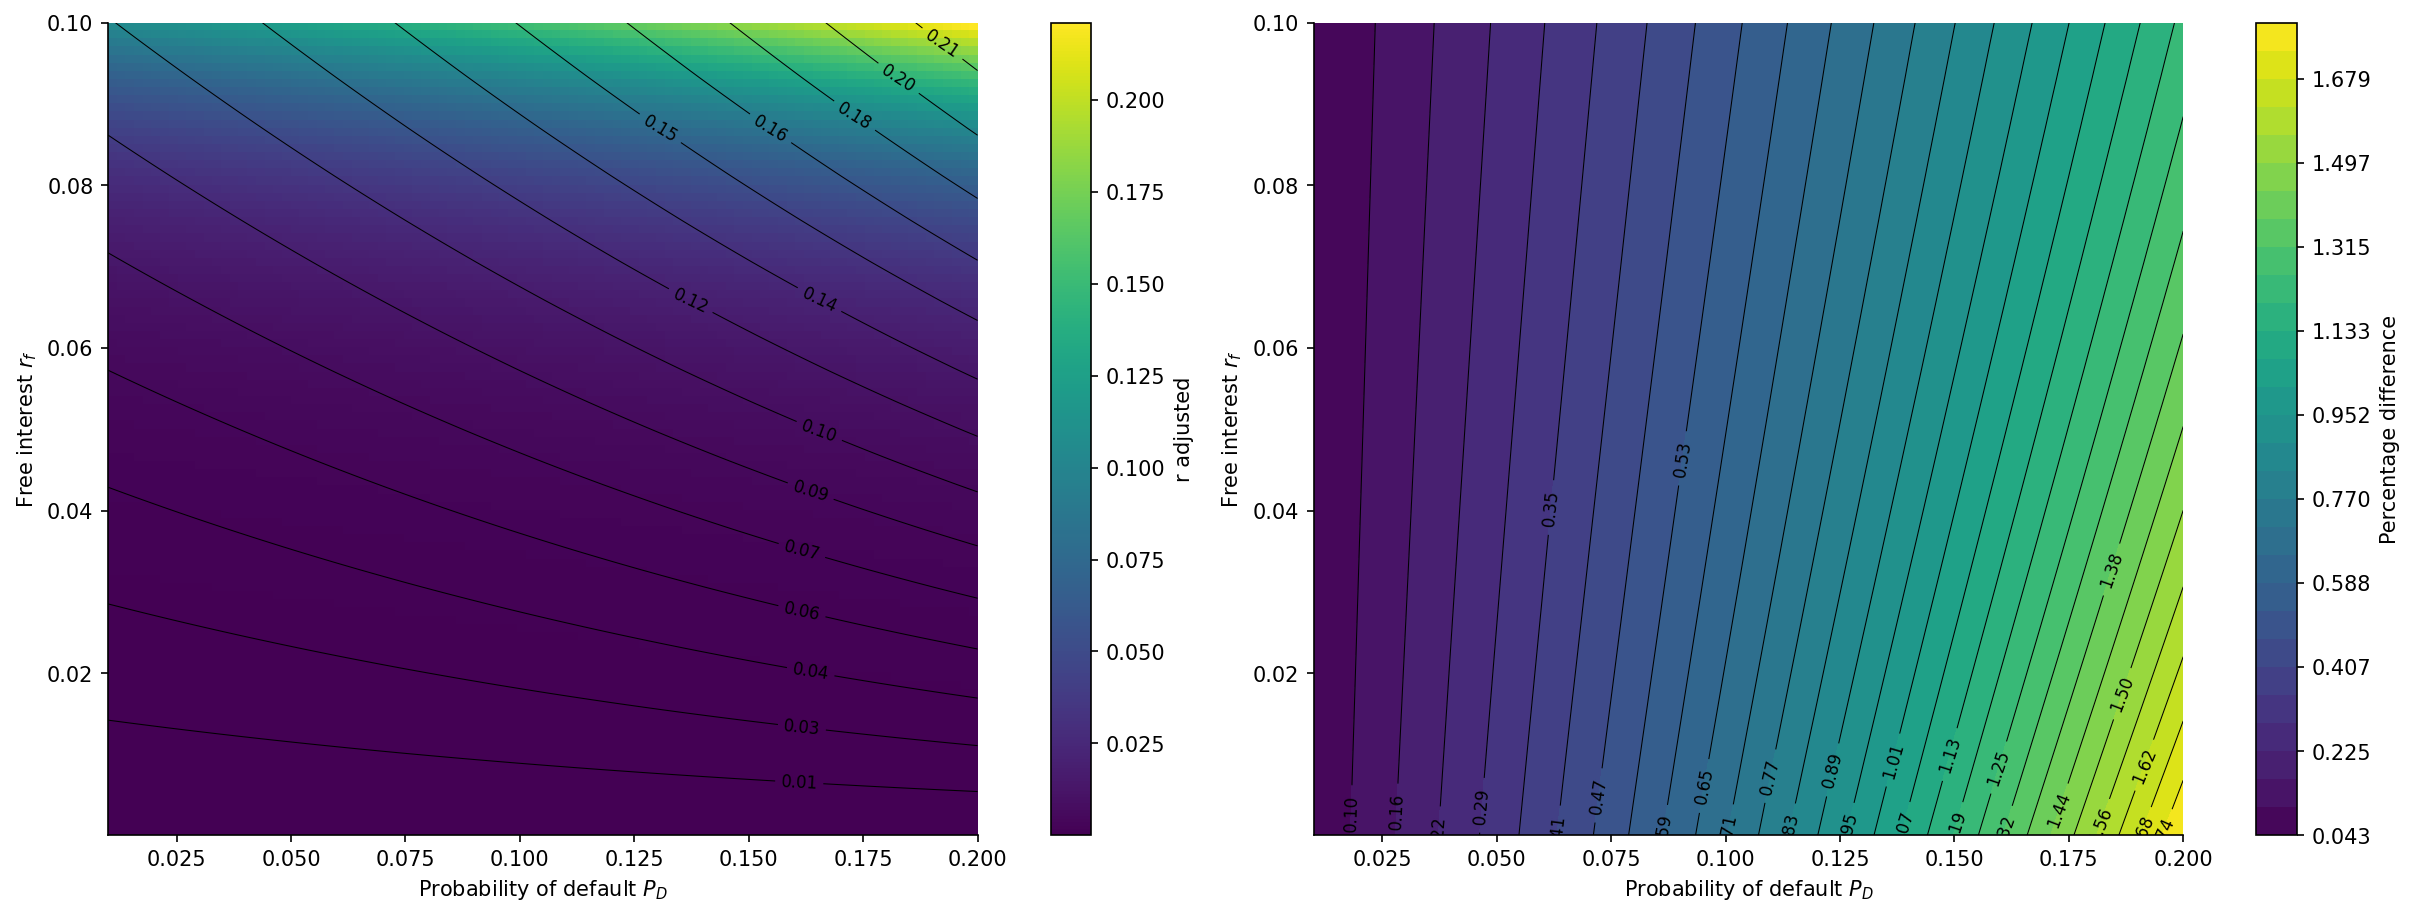

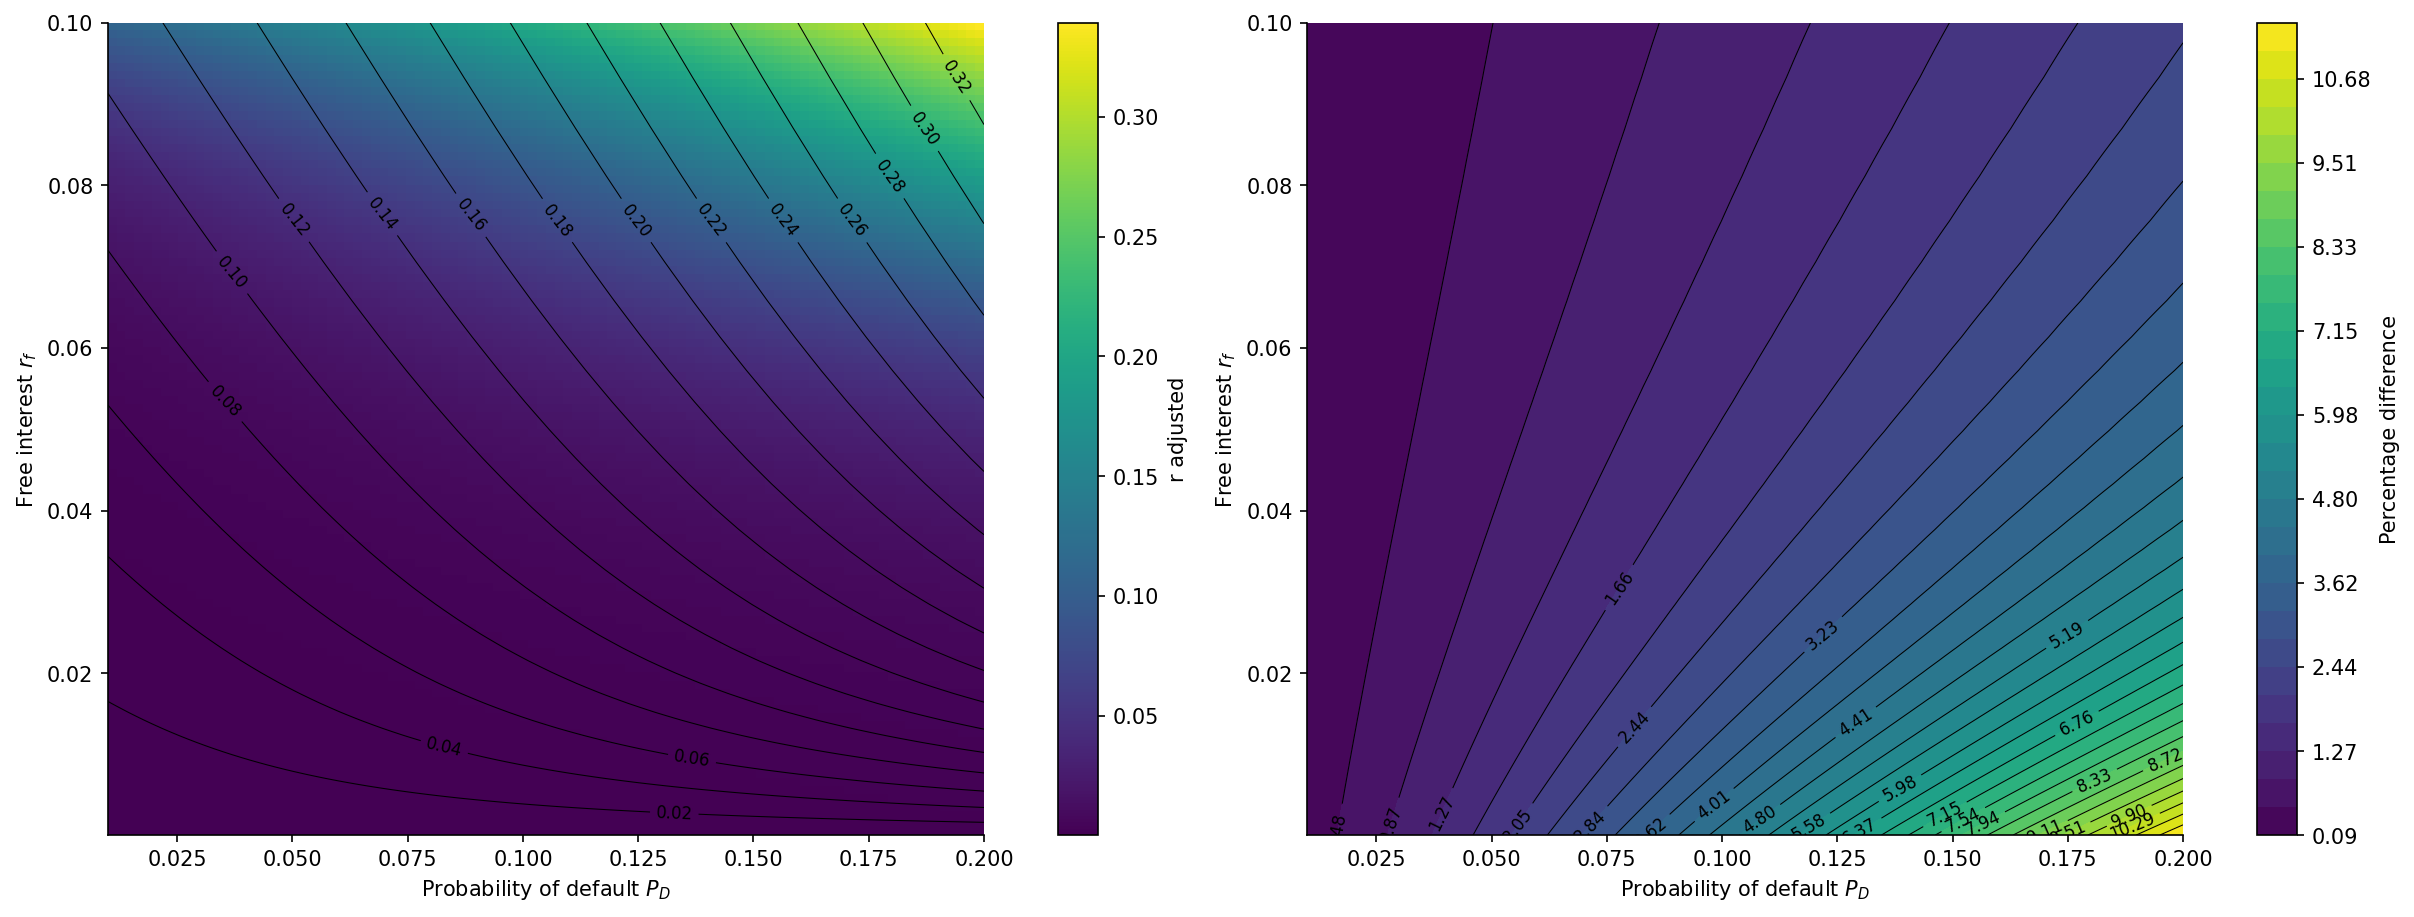

In [10]:
bisect_adjusted_r(T=10)
bisect_adjusted_r(T=50)
# bisect_adjusted_r(T=700)